# Reproduction of  Text Categorization with SVMs

**Paper:** Text Categorization with Support Vector Machines: Learning with Many Relevant Features<br>
**Source:** https://dl.acm.org/citation.cfm?id=649721

The paper suggests the suitability of Support Vector Machines for text classification purposes. In this notebook I am trying to reproduce the results obtained in the paper.

**Datasets:**
- Reuters: http://disi.unitn.it/moschitti/corpora/Reuters21578-Apte-90Cat.tar.gz     
- Ohsumed: http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz

Unzip the datasets into a directory called `./datasets`

**Note:** This notebook needs a Python 2 kernel because of the svmlight package and if you don't want to do the training yourself the results are stored in `./results.tar.gz`

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from multiprocessing import Pool
from matplotlib.colors import to_hex
from matplotlib import rc
%matplotlib inline
pd.set_option('precision', 3) # for better readability of tables

sns.set_palette("husl")
COLORS = sns.color_palette()
COLOR_REU = COLORS[0] # color used for reuters data
COLOR_OHS = COLORS[3] # color used for ohsumed data
rc('text', usetex=True)

## Data Preprocessing

The experiment in the paper used two data sets namely Reuters-21578 and Ohsumed.
First the Reuters-21578 corpus which consists of 21,578 documents including documents without classifications and typographical errors was split into the “ModApte” subset. Each document in this subset is annotated with one or more topics out of 90. The paper reported to have found 9603 training and 3299 test documents. Due to decoding errors (documents containing unknown characters) I ended up with 7768 training and 3019 test documents.

The second data set were documents containing medical abstracts from the MeSH categories of the year 1991. The documents were annotated with 23 categories representing cardiovascular diseases. The author used the first 20,000 documents (10,000 for training and testing each).


### Reading the data

A couple of helper functions to read the training/test data

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MultiLabelBinarizer
from os.path import basename
from collections import defaultdict
from multiprocessing import Pool

def read_files_in_cat(dir):
    for fp in glob.glob(dir + '/*'):
        with open(fp, 'r') as file:
            yield (basename(fp), file.read())

            
def read_set(dir_with_categories):
    for cat_dir in glob.glob(dir_with_categories + '/*'):
        cat_name = basename(cat_dir)
        if cat_name != 'unknown':
            for doc_name, doc_text in read_files_in_cat(cat_dir):
                yield (cat_name, doc_name, doc_text)

def read_doc_files(dir_with_categories):
    labels = defaultdict(list)
    texts = {}
    for cat_name, doc_name, doc_text in read_set(dir_with_categories):
        # same document just other category
        if doc_name not in texts:
            texts[doc_name] = doc_text
        labels[doc_name].append(cat_name)

    for doc_name in texts.iterkeys():
        yield (texts[doc_name], labels[doc_name], doc_name)

### Vectorization & Information Gain

In order to use the documents for training/testing we vectorize them into feature vectors. The dataset gets compiled into a matrix of feature vectors where each row represents a document and column a feature. In this case features are **normalized TF-IDF** (Term Frequency - Inverse Document Frequency) values. The terms are the word stems (without low occurring and stop words) that make up all documents. Categories are also vectorized into a binary label matrix.

The benchmarking will be done with different training set sizes. Like in the paper we will use $\{500, 1,000, 2,000, 5,000, 10,000, all\}$ best features.

In [2]:
# get best k features based on information gain
def best_ks(tup):
    X_train, y_train, X_test, y_test, label, k = tup
    
    # best features for label
    if k:
        kb = SelectKBest(mutual_info_classif, k=k)
        X_train_best = kb.fit_transform(X_train, y_train)
        X_test_best  = kb.transform(X_test)
        return k, label, X_train_best, y_train, X_test_best, y_test
    else:
        return k, label, X_train, y_train, X_test, y_test
        
# read and vectorize training/test data
def read_dataset(path, best_features=[500,1000,2000,5000,10000,None]):
    test_texts, test_labels, test_doc_names    = zip(*read_doc_files(path + '/test'))
    train_texts, train_labels, train_doc_names = zip(*read_doc_files(path + '/training'))
    
    # ordered by term-frequency across corpus
    # tfc -> tf-idf + l2 normalization (cosine) i.e. document vector length = 1
    vectorizer = TfidfVectorizer(min_df=3, norm='l2', use_idf=True, stop_words='english', decode_error='ignore')
    
    X_train = vectorizer.fit_transform(train_texts)
    X_test  = vectorizer.transform(test_texts)
    
    # create binary label indicator matrix 
    mlb = MultiLabelBinarizer()
    Y_train = mlb.fit_transform(train_labels)
    Y_test  = mlb.transform(test_labels)
    
    # select best features using information gain criterion
    args = [(X_train, Y_train[:,label_col], X_test, Y_test[:,label_col], mlb.classes_[label_col],k)
            for k in best_features
            for label_col in range(len(mlb.classes_))]
    
    pool = Pool(8)
    res = defaultdict(dict)
    for k, label, X_train, y_train, X_test, y_test in pool.map(best_ks, args):
        res[k][label] = (X_train, y_train, X_test, y_test)
        
    pool.terminate()
    
    return res

## Classification Algorithms

#### SVM

We use svmlight package that was advertised on the authors webpage: http://svmlight.joachims.org. Polynomial kernels with degree $d \in [1 .. 5]$ as well as rbf kernels with $\gamma \in \{0.6, 0.8, 1.0, 1.2\}$ were used in the paper and positive classification results were interpreted as being of a certain category and negative results the opposite way.

In [ ]:
import svmlight

def to_svmlight_format(sparse_mat, labels):
    lil = sparse_mat.tolil()
    return [(label, zip(row, data))
            for (row, data, label) in zip(lil.rows, lil.data, labels)]

def svm(train_docs, train_labels, test_docs, params):
    
    kernel, param = params
    
    # 0 = want to know, -1 = it's not, 1 = it is
    train_docs_svm = to_svmlight_format(train_docs, (1 if l == 1 else -1 for l in train_labels))
    test_docs_svm  = to_svmlight_format(test_docs, np.zeros(test_docs.shape[0]))
    
    if kernel == 'rbf':
        model = svmlight.learn(train_docs_svm, type='classification',
                               kernel='rbf', rbf_gamma=param)
    elif kernel == 'poly' or kernel == 'polynomial':
        model = svmlight.learn(train_docs_svm, type='classification',
                               kernel='polynomial', poly_degree=param)
    else:
        raise ValueError('Unsupported svm parameters: ' + str(params))
  
    margins = svmlight.classify(model, test_docs_svm)
    predict_labels = [1 if p > 0 else 0 for p in margins]
    
    return predict_labels

#### Naive Bayes
The paper didn’t specify which implementation of the Bayes classifier was used therefore we use the common Multinomial Naive Bayes algorithm for text classification.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes(train_docs, train_labels, test_docs, params):
    nb = MultinomialNB()
    nb.fit(train_docs.toarray(), train_labels)
    predict_labels = nb.predict(test_docs.toarray())
    return predict_labels

#### Rocchio

Even though the Nearest Centroid algorithm is not called Rocchio, when it is applied to text classification (with TF-IDF vectors) it is. This algorithm will be used with $\beta \in \{0, 0.1, 0.25, 0.5, 1\}$.

In [ ]:
from sklearn.neighbors import NearestCentroid

def rocchio(train_docs, train_labels, test_docs, params):
    beta = params
    nc = NearestCentroid(shrink_threshold=beta)
    nc.fit(train_docs.toarray(), train_labels)
    predict_labels = nc.predict(test_docs.toarray())
    return predict_labels

#### C4.5

This is the only algorithm which is not the same as in the original paper. According to sklearn’s website the implementation chosen is called CART and is very similar to C4.5. It only differs in that it also supports numerical target variables (regression) and does not compute rule set.

In [ ]:
from sklearn import tree

def tree_cart(train_docs, train_labels, test_docs, params):
    tree_classifier = tree.DecisionTreeClassifier() # TODO: Uses CART not c45
    tree_classifier.fit(train_docs, train_labels)
    predict_labels = tree_classifier.predict(test_docs)
    return predict_labels

#### k-NN

Finally also k-NN will be run with different parameters $k \in \{1, 15, 30, 45, 60\}$.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

def kNN(train_docs, train_labels, test_docs, params):
    k = params
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_docs, train_labels)
    predict_labels = neigh.predict(test_docs)
    return predict_labels

## Training & Prediction

Because the benchmarking is quite big we will serialize all the parameters and algorithms into tuples.

In [ ]:
KNN_VERS     = [('k-NN', k) for k in [1,15,30,45,60]]
ROCCHIO_VERS = [('Rocchio', beta) for beta in [0.0,0.1,0.25,0.5,1.0]]
BAYES_VERS   = [('MNBayes', None)]
CART_VERS    = [('TreeCART', None)]
SVM_VERS     = [('SVM', params)
                for params in [('poly',deg)   for deg   in [1,2,3,4,5]] +
                              [('rbf', gamma) for gamma in [0.6,0.8,1.0,1.2]]]

BEST_FEATURES = [500, 1000, 2000, 5000, 10000, None]
ALGO_FNS = {'k-NN': kNN, 'MNBayes': naive_bayes,
            'TreeCART': tree_cart, 'Rocchio': rocchio, 'SVM': svm}

# REUTERS = read_dataset('datasets/Reuters21578-Apte-90Cat')
# OHSUMED = read_dataset('datasets/ohsumed-first-20000-docs')
# DATASETS = {'reuters': REUTERS, 'ohsumed': OHSUMED}

Helper classes/functions to abstract over prediction and parallelization of all algorithms.

In [3]:
import re

# Helper class for reading/writing data to disk and orchestrating training/test
class Algo():
    
    def __init__(self, name, params, features, dataset_name):
        self.name = name
        self.dataset_name = dataset_name
        self.features = features
        self.params = params
        
    def __repr__(self):
        if self.params != None:
            if isinstance(self.params,list) or isinstance(self.params,tuple):
                params_name = '_'.join(map(str, self.params))
            else:
                params_name = str(self.params)
        else:
            params_name = ''
        
        return self.name + ' ' + params_name + (' ' if self.params != None else '') +\
               str(self.features) + 'F ' + self.dataset_name

    @staticmethod
    def from_filepath(fp):
        base = re.sub(' (predict|true)_labels.csv','', os.path.basename(fp))
        
        parts = base.split(' ')
        if len(parts) == 3:
            algo_name, features, dataset_name = parts
            params = None
        elif len(parts) == 4:
            algo_name, params, features, dataset_name = parts
        else:
            raise ValueError('Unexpected filepath: ' + fp)

        return Algo(algo_name, params,
                    None if features == 'NoneF' else int(re.sub('F','',features)),
                    dataset_name)

def predict_algo(algo):
    print(algo)
    
    label_data = DATASETS[algo.dataset_name][algo.features]
    labels = list(label_data.iterkeys())
    
    predicts = defaultdict(dict)
    for label, (X_train, y_train, X_test, y_test) in label_data.iteritems():
        predicts[label] = ALGO_FNS[algo.name](X_train, y_train, X_test, algo.params)
    
    pd.DataFrame(
        data  = [label_data[l][3] for l in labels], # true labels
        index = labels
    ).to_csv('results/' + str(algo) + ' true_labels.csv')
    
    pd.DataFrame(
        data  = map(predicts.get, labels),
        index = labels
    ).to_csv('results/' + str(algo) + ' predict_labels.csv')
    
    print()
    return str(algo) + ' DONE'

# check whether algorithms have prediction results
def missing(algos_to_run):
    already_run = set(map(lambda fp: str(Algo.from_filepath(fp)), glob.glob('results/*')))
    return list(filter(lambda algo: str(algo) not in already_run, algos_to_run))

### Train models

Unfortunately parallel processing is somewhat buggy (especially with the rocchio algorithm for some reason). Therefore `predict_algo` writes to disk immediately after finishing training that algorithm.

**Note:** Training takes a very long time because the datasets are very big

In [ ]:
from multiprocessing import Pool

algos_to_run = [Algo(name, params, best_feat, 'reuters')
                for best_feat in BEST_FEATURES
                for name, params in (SVM_VERS + KNN_VERS + BAYES_VERS + CART_VERS + ROCCHIO_VERS)]

USE_MULTIPLE_CORES = True

if USE_MULTIPLE_CORES:
    pool = Pool(processes=8)
    result = pool.map(predict_algo, missing(algos_to_run))
    pool.terminate()
else:
    map(predict_algo, missing(algos_to_run))

## Evaluation of predictions

### Distribution of dataset


Before inspecting the results we should notice that the Reuters data set is heavily skewed towards a few select categories. This will influence some of the testing later on.

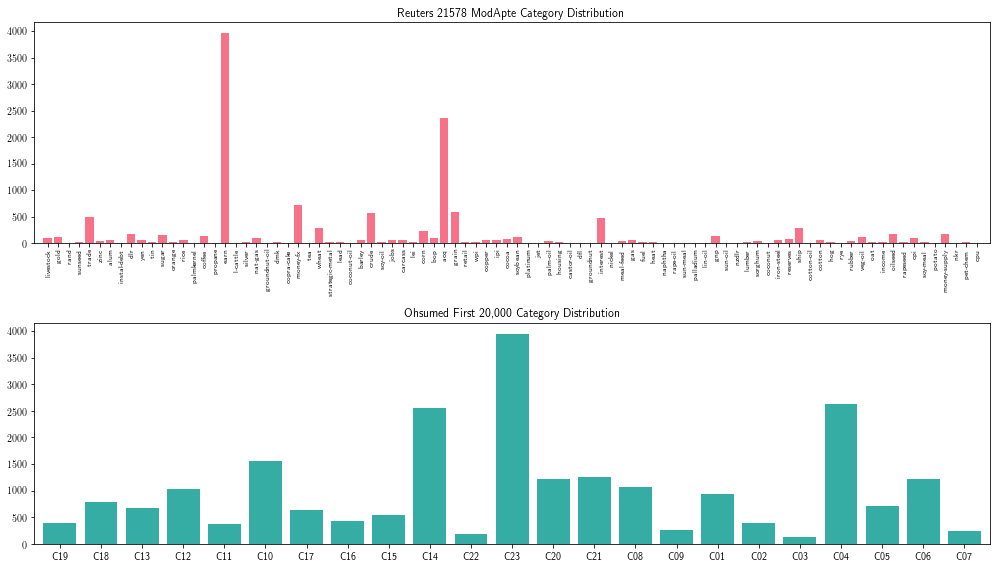

In [14]:
def label_dist(dataset_name):
    def dist(path):
        _, test_labels,  _ = zip(*read_doc_files(path + '/test'))
        _, train_labels, _ = zip(*read_doc_files(path + '/training'))
        labels = np.concatenate(test_labels + train_labels)
        return dict(zip(*np.unique(labels, return_counts=True)))
    
    if dataset_name == 'reuters':
        return dist('datasets/Reuters21578-Apte-90Cat')
    elif dataset_name == 'ohsumed':
        return dist('datasets/ohsumed-first-20000-docs')

def show_label_dists():
    labels_reu = label_dist('reuters')
    labels_ohs = label_dist('ohsumed')

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(14, 8)
    
    ax1.set_title('Reuters 21578 ModApte Category Distribution')
    ax1.bar(labels_reu.keys(), labels_reu.values(), align='center', color=COLOR_REU)
    ax1.margins(x=0.01)
    plt.setp(ax1.get_xticklabels(), rotation=90, fontsize=7)

    ax2.set_title('Ohsumed First 20,000 Category Distribution')
    ax2.bar(labels_ohs.keys(), labels_ohs.values(), align='center', color=COLOR_OHS)
    ax2.margins(x=0.01)

    plt.tight_layout()
    plt.savefig('label_dist.pdf')
    plt.show()
    
show_label_dists()

### Compile prediction evaluations

In order to evaluate the prediction quality we create dataframes consisting of F1 scores.

In [4]:
from collections import defaultdict
from sklearn.metrics import f1_score

def f1s_from_preds(dataset_name):
    
    algo_series = []
    f1_micro = {}
    
    for fp in filter(lambda fp: dataset_name in fp, glob.glob('results/*')):
        
        algo = Algo.from_filepath(fp)
        
        if str(algo) not in f1_micro:
            
            predicts = pd.read_csv('results/' + str(algo) + ' predict_labels.csv', index_col=0)
            trues    = pd.read_csv('results/' + str(algo) + ' true_labels.csv', index_col=0)
            #
            algo_series.append(
                pd.Series([f1_score(trues.loc[label], predicts.loc[label])
                           for label in predicts.index],
                          index=predicts.index, name=str(algo))
            )

            f1_micro[str(algo)] = f1_score(trues, predicts, average='micro')
    
    df = pd.concat(algo_series, axis=1)
    return df.sort_index(axis=1), f1_micro


# best classification results that contain keywords
def best(df, f1_micro, list_of_keywords):   
    cols = []
    for keywords in list_of_keywords:
        ks = keywords if isinstance(keywords, tuple) or isinstance(keywords,list) else [keywords]
        filtered = dict(
            filter(lambda algo_f1: all(str(k) in algo_f1[0] for k in ks),
                   f1_micro.iteritems())
        )
        best_f1 = max(filtered, key=filtered.get)
        cols.append(best_f1)
        
    return df[cols], {c: f1_micro[c] for c in cols}

# get top 10 categories in reuters dataset
def top_10_reuters(df, f1_micro):
    svms = [['SVM','poly_' + str(d), 'reuters'] for d in range(1,6)] +\
           [['SVM','rbf_' + str(g), 'reuters']  for g in [0.6,0.8,1.0,1.2]]
    cats = [['Bayes','reuters'], ['Rocchio','reuters'], ['CART','reuters'], ['k-NN','reuters']] + svms
    
    best_df, best_f1_micro = best(df, f1_micro, cats)
    
    popular = ['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest', 'ship', 'wheat', 'corn']
    
    return best_df.loc[popular].append(pd.Series(best_f1_micro, name='F1 microavg.')).round(2)
    
# best algorithm version, filter by categories
def best_all(df, f1_micro, categories=None, dropzeros=False):
    svms = [['SVM','poly_' + str(d)] for d in range(1,6)] +\
           [['SVM','rbf_' + str(g)] for g in [0.6,0.8,1.0,1.2]]
    algos = ['Bayes', 'Rocchio', 'CART', 'k-NN'] + svms
    
    best_df, best_f1_micro = best(df, f1_micro, algos)
    
    if categories:
        best_df = best_df.loc[categories]
        
    return best_df, pd.Series(best_f1_micro, name='F1 microavg.')
    
    # best_cats_nonzero_df = best_cats_df.loc[~(best_cats_df==0).any(axis=1)] if dropzeros else best_cats_df
    # return best_cats_nonzero_df, pd.Series(best_f1_micro, name='F1 microavg.')

def most_used_categories(dataset_name, best_percent):
    labels = label_dist(dataset_name)
    hist = pd.Series(labels).sort_values()
    return list(hist[hist >= hist.quantile(1 - best_percent)].index)

In [6]:
# might take a while
DF_REU, F1_REU = f1s_from_preds('reuters');
DF_OHS, F1_OHS = f1s_from_preds('ohsumed');

### F1 scores per algorithms

To get a sense of the overall prediction quality we will aggregate all F1 scores per algorithm regardless of parameters and see how they distribute. Pink like before is the Reuters dataset and teal Ohsumed. The transparent histogram is normalized and the opaque absolute.

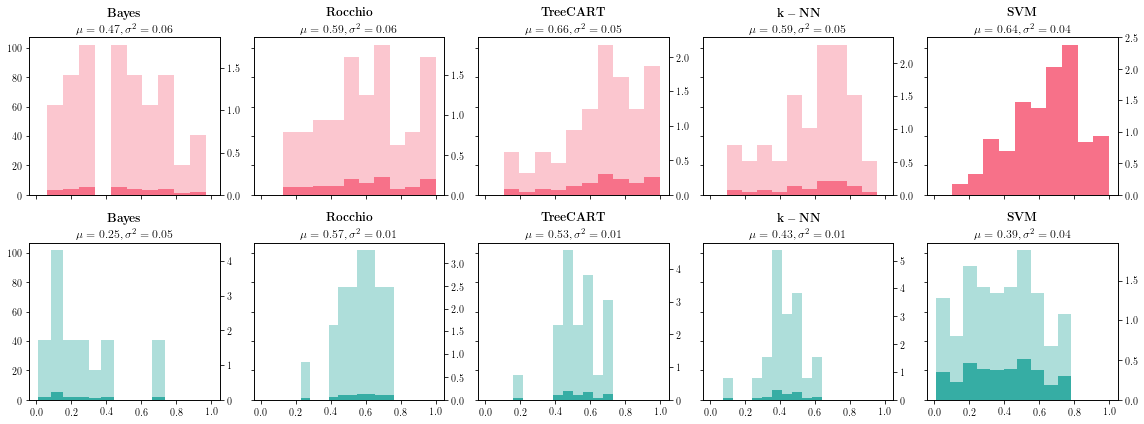

In [22]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
fig.set_size_inches(16, 6)

algos = ['Bayes','Rocchio', 'TreeCART', 'k-NN', 'SVM']
args_reu = [(ax, algo, best_all(DF_REU,F1_REU)[0], COLOR_REU) for (ax, algo) in zip(axs[0], algos)]
args_ohs = [(ax, algo, best_all(DF_OHS,F1_OHS)[0], COLOR_OHS) for (ax, algo) in zip(axs[1], algos)]

for ax, algo, df, color in args_reu + args_ohs:
    
    all_f1s = df.filter(regex=algo).values.flatten()
    all_f1s_nonzero = all_f1s[all_f1s > 0.0]
    var = str(round(np.var(all_f1s_nonzero), 2))
    mu  = str(round(np.mean(all_f1s_nonzero), 2)) 
    
    ax.set_title(r'$\bf{' + algo + '}$\n' + '$\mu=' + mu + ', \sigma^2=' + var + '$')
    ax.hist(all_f1s_nonzero, color=color, bins=10)
    
    # plot normalized    
    ax2 = ax.twinx()
    ax2.hist(all_f1s_nonzero, color=(to_hex(color) + '66'), normed=True)


plt.tight_layout()
plt.show()

### Do SVMs have significantly higher F1-Scores?

Finally the big statement of the paper was that SVMs outperform the other 4 classification algorithms in text classification tasks. To investigate this we will visualize the algorithms in a matrix where each cell contains the p-value of whatever test metric we pick.

In [9]:
def pval_matrix(df, f1_micro, test, alpha):
    
    res = defaultdict(list)
    
    for algo1 in df:
        for algo2 in df:
            res[algo1].append(test(df[algo1], df[algo2]).pvalue)
    
    clean_names = [algo.name + (' ' + str(algo.params) if algo.params else '')
                   for algo in map(Algo.from_filepath, df.columns)]
    
    df_pvals = pd.DataFrame.from_dict(res)[df.columns].round(3)
    
    clean_to_full = dict(zip(clean_names, df_pvals.columns))
    
    def color_cell(f1_row, f1_col):
        if f1_row < f1_col:
            return 'background-color: '  + to_hex(COLORS[4]) + '22' # blue
        else:
             return 'background-color: ' + to_hex(COLORS[5]) + '22' # pink
    
    def color_col(col):
        stylings = ['' if pval > alpha
                    else color_cell(f1_micro[clean_to_full[row_name]], f1_micro[clean_to_full[col.name]])
                    for (pval, row_name) in zip(df_pvals[col.name], df_pvals.columns)]
        return stylings

    df_pvals.index = clean_names
    df_pvals.columns = clean_names
    df_pvals_styled = df_pvals.style.apply(color_col, axis=0)

    return df_pvals_styled

Because we don't have very many samples we use a **pairwise t-test** with $\alpha = 0.05$. If a cell is colored pink then the row has a significantly higher mean F1 score. Also due to the skewed category distribution we will only compare the most popular categories (which make up 70%).

In [15]:
from scipy.stats import ttest_ind, ranksums, normaltest

# only take most popular categories which take up x% because reuters category distribution is skewed
df_reu_best, f1_reu_best = best_all(DF_REU, F1_REU, most_used_categories('reuters', 0.7))

# print('Blue = Column > Row, Green = the other way')
pval_matrix(df_reu_best, f1_reu_best, ttest_ind, 0.05)

,MNBayes,Rocchio 0.0,TreeCART,k-NN 15,SVM poly_1,SVM poly_2,SVM poly_3,SVM poly_4,SVM poly_5,SVM rbf_0.6,SVM rbf_0.8,SVM rbf_1.0,SVM rbf_1.2
MNBayes,1,0,0,0,0,0,0,0,0,0,0,0,0
Rocchio 0.0,0,1,0.025,0.031,0.183,0.313,0.879,0.448,0.039,0.8,0.986,0.387,0.19
TreeCART,0,0.025,1,0,0.469,0.285,0.036,0.005,0,0.086,0.05,0.005,0.001
k-NN 15,0,0.031,0,1,0.002,0.004,0.07,0.169,0.828,0.03,0.055,0.228,0.421
SVM poly_1,0,0.183,0.469,0.002,1,0.754,0.186,0.054,0.002,0.339,0.232,0.048,0.018
SVM poly_2,0,0.313,0.285,0.004,0.754,1,0.3,0.102,0.005,0.507,0.364,0.089,0.035
SVM poly_3,0,0.879,0.036,0.07,0.186,0.3,1,0.595,0.089,0.717,0.904,0.524,0.299
SVM poly_4,0,0.448,0.005,0.169,0.054,0.102,0.595,1,0.217,0.362,0.512,0.896,0.58
SVM poly_5,0,0.039,0,0.828,0.002,0.005,0.089,0.217,1,0.038,0.069,0.291,0.527
SVM rbf_0.6,0,0.8,0.086,0.03,0.339,0.507,0.717,0.362,0.038,1,0.81,0.316,0.161


As we can see SVMs seem to have a slight edge (especially against Bayes) but we weren't able to observe anything conclusive.

### Did we get the same results as the paper?

This table was copied manually from the original paper and then compared with our results.

In [16]:
DF_PAPER = pd.DataFrame(
    columns = ['Bayes', 'Rocchio', 'C4.5', 'k-NN', 'SVM p1', 'SVM p2', 'SVM p3', 'SVM p4', 'SVM p5', 'SVM r0.6', 'SVM r0.8', 'SVM r1.0', 'SVM r1.2'],
    index = ['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest', 'ship', 'wheat', 'corn', 'F1 microavg.'],
    data =\
    [[95.9, 96.1, 96.1, 97.3,  98.2, 98.4, 98.5, 98.4, 98.3,  98.5, 98.5, 98.4, 98.3],
     [91.5, 92.1, 85.3, 92.0,  92.6, 94.6, 95.2, 95.2, 95.3,  95.0, 95.3, 95.3, 95.4],
     [62.9, 67.6, 69.4, 78.2,  66.9, 72.5, 75.4, 74.9, 70.2,  74.0, 75.4, 76.3, 75.9],
     [72.5, 79.5, 89.1, 82.2,  91.3, 93.1, 92.4, 91.3, 89.9,  93.1, 91.9, 91.9, 90.6],
     [81.0, 81.5, 75.5, 85.7,  86.0, 87.3, 88.6, 88.9, 87.8,  88.9, 89.0, 88.9, 88.2],
     [50.0, 77.4, 59.2, 77.4,  69.2, 75.5, 76.6, 77.3, 77.1,  76.9, 78.9, 77.8, 76.8],
     [58.0, 72.5, 49.1, 74.0,  69.8, 63.3, 67.9, 73.1, 76.2,  74.4, 75.9, 76.2, 76.1],
     [78.7, 83.1, 80.9, 79.2,  82.0, 75.4, 86.0, 86.5, 86.0,  85.4, 86.5, 87.6, 87.1],
     [60.6, 79.4, 85.5, 76.6,  83.1, 84.5, 85.2, 85.9, 83.8,  85.2, 85.9, 85.9, 85.9],
     [47.3, 62.2, 87.7, 77.9,  86.0, 86.5, 85.3, 85.7, 83.9,  85.1, 85.7, 85.7, 84.5],
     
     [72.0, 79.9, 79.4, 82.3,  84.2, 85.1, 85.9, 85.7, 85.9,  86.4, 86.5, 86.3, 86.2]
    ]
)

In order to compare whether our results stem from the same distribution we do a chi-square test between the columns of the scores we obtained and the copied ones.

**Significance Test (Chi-Square)**<br>
*Hypothesis 0:* Paper scores are not significantly different from reproduced scores<br>
*Hypothesis 1:* They are significantly different

In [18]:
from scipy.stats import chisquare

DF_REU_TOP = top_10_reuters(DF_REU, F1_REU)

for i, (reu,paper) in enumerate(zip(DF_REU_TOP.columns, DF_PAPER.columns)):
    print(reu + ' - ' + paper + ' = '
          + str(chisquare(DF_PAPER.iloc[:,i], DF_REU_TOP.iloc[:,i]).pvalue))

MNBayes 1000F reuters - Bayes = 0.0
Rocchio 0.0 NoneF reuters - Rocchio = 0.0
TreeCART 1000F reuters - C4.5 = 0.0
k-NN 15 NoneF reuters - k-NN = 0.0
SVM poly_1 5000F reuters - SVM p1 = 0.0
SVM poly_2 5000F reuters - SVM p2 = 0.0
SVM poly_3 NoneF reuters - SVM p3 = 0.0
SVM poly_4 2000F reuters - SVM p4 = 0.0
SVM poly_5 2000F reuters - SVM p5 = 0.0
SVM rbf_0.6 2000F reuters - SVM r0.6 = 0.0
SVM rbf_0.8 2000F reuters - SVM r0.8 = 0.0
SVM rbf_1.0 2000F reuters - SVM r1.0 = 0.0
SVM rbf_1.2 2000F reuters - SVM r1.2 = 0.0


It's very unlikely that rejecting hypothesis 0 is a mistake.

## Conclusion

Unfortunately it looks like we were not able to reproduce the results. 